# Elementary Routing  Part 1

## Introduction

In this notebook, I introduce, mainly to myself, some elementary notions related to the __[Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem)__ (VRP). Specifically, I focus on the __[Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)__ by going through the basic problem formulation and its solution using the IBM&copy; ILOG&copy; CPLEX optimization suite. This introduction has been motivated by related problems which I have had the pleasure of working with as a Data Scientist Trainee at IBM Finland. For the technicalities, I follow __[The Vehicle Routing Problem](https://doi.org/10.1137/1.9780898718515)__, the relavant part of which is the first overview chapter. Other references are provided in the following as needed but I have found in particular __[IBM&copy; Decision Optimization Tutorial](https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/mp/index.html)__ useful. 

In order to make this light introduction, since its soon Christmas, even lighter, I have decided to phrase it in terms of a backstory which goes as follows. It is Christmas Eve, HRK has promised to be a surrogata Santa for some of her friends families with children. True Santa is unable to make it this year and HRK hopes to save the childrens Christmases. Only thing, is that she has promized to help four families, requests kept coming and she could not refuse, and she is not sure how she can make it. HRK decides to prepare for the Christmas Eve systematically so that she does not fail anyones expectations. Having heard about decision optimization, she decides a give a go at finding an optimal plan how to visit the families. 

In the following, we will examine her problem, restate it as a mathematical model and finally solve it numerically to arrice at an optimal visiting plan.

## 1 Preliminariies

The required libraries listed in

In [1]:
import googlemaps
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from datetime import datetime
from docplex.mp.model import Model

are all freely available.

## 2 Data

In order to prepare a travel plan, we first need some estimates of how long does it take to go from one home to another. We know that she plans to use her electric car to make the trips. Then the travel times can be easily extracted from Google Maps using the __[googlemaps](https://googlemaps.github.io/google-maps-services-python/docs/#)__ python library. Some easy to understand use instructions can be found from __[Getting started with Google Maps in Python](https://blog.goodaudience.com/google-maps-in-python-part-2-393f96196eaf)__. We start by listing the latitude and longitude coordinates of the homes she is going to visit.

In [2]:
location=[
    '60.199462,24.876161',
    '60.219266,24.780629',
    '60.292905,25.044046',
    '60.210470,24.964479',
    '60.159734,24.876626'
    ]

Next, we write a function which extracts the travel times between the homes. This requires a __[Google Maps API key](https://developers.google.com/maps/documentation/embed/get-api-key)__, which is here read from a local file. Furthermore, we need to fix the date and time when the visits are to made. For this, we choose the Christmas Eve at 4pm thereby assuming that this choice is a good representative for all of the travel times. 

In [3]:
with open('google_apikey.txt') as f:
    api_key=f.readline().rstrip('\n')
    f.close

In [4]:
def get_distance(a,b):
    gmaps=googlemaps.Client(key=api_key)
    now=datetime(2018,12,24,16)
    directions=gmaps.directions(
        a,
        b,
        mode='driving',
        departure_time=now)
    return directions[0]['legs'][0]['duration']['value']

The travel times for the locations of interest can now be easily extracted and stored to a cost matrix the purpose of which becomes soon clear.

In [5]:
n=len(location)
cost=np.zeros((n,n))
for i in range(n):
    for j in range(n):
        cost[i,j]=get_distance(location[i],location[j])/3600

It is noteworthy that the travel times are stored in units of hours, They are moreover asymmetric meaning that the direction in which a tour is taken matters.

## 3 Traveling Santa Problem

It is quickly found that HRKs problem, as stated above, is the __[Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)__ (TSP) which is about finding an optimal tour visiting each location of a set of locations exactly once. Having read on this problem, we find that the integer programming formulation of TSP can be stated as follows.

Given a set of $n$ locations indexed by $[1,n]\cap\mathrm{Z}$, TSP is solved by

\begin{align}
    \min_{x}\sum_{i,j=1}^{n}
    \sum_{\substack{j=1\\j\neq i}}^{n}
    x_{ij}c_{ij}
\end{align}

when

\begin{align}
    x_{ij}
    &\in\{0,1\}
    &\forall i,j\in[1,n]\cap\mathrm{Z}
\end{align}

subject to

\begin{align}
    \sum_{\substack{i=1\\i\neq j}}^{n} x_{ij}
    &=1 & \forall j\in[1,n]\cap\mathrm{Z}
    \, ,\\
    \sum_{\substack{j=1\\j\neq i}}^{n} x_{ij}
    &=1 & \forall i\in[1,n]\cap\mathrm{Z}
    \, ,
\end{align}

and

\begin{align}
    u_{i}
    &\in\mathrm{Z}
    \, ,\\
    u_{i}-u_{j}+nx_{ij}
    &\leq n-1
    & \forall i\neq j; 
    i,j\in[2,n]\cap\mathrm{Z}\, ,
    \, ,\\
    1\leq u_{i}
    &\leq n-1
    & \forall i\in[2,n]\cap\mathrm{Z}\, ,
\end{align}

Here, $x_{ij}$ is a binary variable denoting whether or not a route between locations $i$ and $j$ is taken while $c_{ij}$ denotes the travel time for this route. The equality constraints enforce that each location is visited exactly once. The inequality constraints known as the Miller-Tucker-Zemlin (MTZ) constraints eliminate subtours which guarantees that the plan can be executed. Instead of MTZ constraints, also the subtour elimination constraints

\begin{align}
    \sum_{i\in S}\sum_{j\notin S} x_{i}
    &\geq\lvert S \rvert
    & \forall S\subset [1,n]\cap\mathrm{Z},S\neq \emptyset
\end{align}

could be used. In general, this would yield tighter formulations for the linear programming relaxations. However,  the downside would be that in a naive implementation the cardinality of the constraint set would become exponential instead of polynomial. 

Having setup the optimization problem, in order to solve it, we refer to the __[IBM&copy; Decision Optimization Tutorial](https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/mp/index.html)__.  This tutorial helps to setup and use the free Community Edition docplex.mp python API for IBM&copy; ILOG&copy; CPLEX optmization suite. More information about CPLEX can be found in the User's Manual found, for example, through __[IBM ILOG CPLEX Optimization Studio V12.6.3 documentation](https://www.ibm.com/support/knowledgecenter/en/SSSA5P_12.6.2/ilog.odms.studio.help/Optimization_Studio/topics/COS_home.html)__. After having read a minimal set of absolutely neccessary information, we can continuos with our task.

First, we define the 'traveling santa problem' aka 'tsp' model

In [6]:
model=Model("tsp")

for which we add both the binary

In [7]:
lbl=range(len(location))
x=model.binary_var_dict(
    [(i, j) for i in lbl for j in lbl],
    name='x')

and integer

In [8]:
u=model.integer_var_dict(
    [i for i in lbl],
    lb=0,
    name='u')

variables described above to the model. This gives the model summary

In [9]:
model.print_information()

Model: tsp
 - number of variables: 30
   - binary=25, integer=5, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults


which evidently lacks the constraints of the problem. To fix this, we can first add the equality constraints

In [10]:
c_1_4=[model.add_constraint(model.sum(x[i,j] for j in lbl)==1) for i in lbl]
c_1_5=[model.add_constraint(model.sum(x[i,j] for i in lbl)==1) for j in lbl]

and define the helper function

In [11]:
def exclude(A,i):
    return [a for a in A if a!=i]

to add the inequality constraints

In [12]:
c_1_13=[]
for i in exclude(lbl,0):
    for j in [k for k in exclude(lbl,0) if k!=i]:
        c_1_13.append(model.add_constraint(u[i]-u[j]+n*x[i,j]<=n-1))
c_1_14=[model.add_constraint(u[i]<=n-1) for i in lbl]

which should now provide a full specification of the varibles of the model. To check this, we print the model summary

In [13]:
model.print_information()

Model: tsp
 - number of variables: 30
   - binary=25, integer=5, continuous=0
 - number of constraints: 27
   - linear=27
 - parameters: defaults


which seems about right. It then remains to complete the model by defining the optimization target. In order to do this, we first state that

In [14]:
for i in range(n): cost[i,i]=1e+12

which is a way to prevent pathological loops from forming. The objective funciton, or in short he loss, is then defined by

In [15]:
loss=model.dot(
    [x[k] for k in sorted(x.keys())],
    cost.flatten())

and the problem is set as a minimization task by

In [16]:
model.minimize(loss)

I believe that we have now fully setup the problem and that CPLEX can be issued to solve it. Indeed, by calling the solve method

In [17]:
solution=model.solve()

we find that everything sofar went as planned. In order to verify that this is really the case, and to access the plan, we need to examine the solution. In the first place, the optimal value of the objective function is 

In [18]:
model.objective_value

1.4475

while the values of the variables $x_{ij}$ and $u_{i}$ are

In [19]:
model.print_solution()

objective: 1.448
  x_0_3=1
  x_1_4=1
  x_2_1=1
  x_3_2=1
  x_4_0=1
  u_1=2
  u_2=1
  u_4=3


which seem like reasonable values. Lastly, to check that the solver was succesful, the solve details can be accessed by calling

In [20]:
model.get_solve_details()

docplex.mp.SolveDetails(time=0.0158172,status='integer optimal solution')

which returns a SolveDetails object. For our purposes, already this minimal output is sufficient, that is, the integer optimal solution was found and it took a fraction of a second to do so.

## 4 Visualization

From the input above, it is not very easy to see that the optimal solution is in fact a tour or to understand how the tour proceeds. In order to visualize the solution in a simple but more transparent way, I decided to lookup a network (graph) library. As the result of a search, I found the __[networkx](https://networkx.github.io)__ library and decided to use it for visualizing the optimal tour. In order to provide networkx the graph induced by the optimal integer solution, it is useful to define the function

In [21]:
def get_edges(x):
    return (k for k,v in x.items() if v.solution_value==1)

which converts the integer variables into a list of tuples describing the edges. It is then straightforward to generate the networkx graph

In [26]:
G=nx.DiGraph()
G.add_edges_from(get_edges(x))

and visualize it using native function calls.

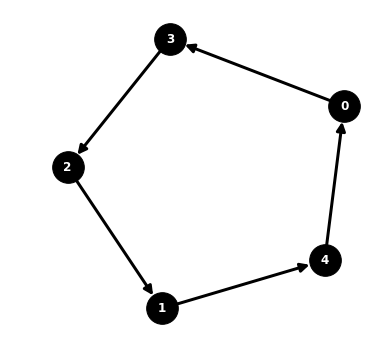

In [32]:
fig,ax=plt.subplots(figsize=(6,6))
options={
    'arrows':True,
    'arrowsize':18,
    'with_labels':True,
    'font_weight':'bold',
    'font_size':12,
    'font_color':'white',
    'node_color':'black',
    'node_size':1000,
    'width':3}

nx.draw(G,ax=ax,**options)

From this visualization it is immediately clear that the solution is a tour and it is also easier to understand how the optimal tour proceeds.

## Conclusions

In this notebook, I went through some elementary aspects related to routing problems by focusing on the travelling salesman problem. I also learned to use some basic functionalities of the IBM IBM&copy; ILOG&copy; CPLEX optimization suite. More importantly, as always with applications, HRK can now happily proceed with her Christmas plan. Curious elves can lookup the tour she is going to make in terms of the actual locations. It seems, however, that the almost two hours, which she needs to reserve for traveling, does not allow her to spend much time with the children. Perhaps some help would be in place, but how to revise the plan to make efficient use of helping hands. Moreover, how does the plan proposed here align with the usual sauna, dinner, etc. schedules of the families. How certain is it that the travel times between the homes are what they are and how does the plan change if the travel times would be unpredictable to some degree. For now, considering such aspects is another story, but perhaps also another opportunity to learn and to post the story.   